In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# --- USER PATHS ---
path_mob_2020 = '../../RAW_DATA/Transportion/2020_IN_Region_Mobility_Report.csv'
path_mob_2021 = '../../RAW_DATA/Transportion/2021_IN_Region_Mobility_Report.csv'
path_mob_2022 = '../../RAW_DATA/Transportion/2022_IN_Region_Mobility_Report.csv'
path_cases    = '../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv'

In [11]:
# 1. Load Mobility Data (2020-2022)
try:
    df_m20 = pd.read_csv(path_mob_2020)
    df_m21 = pd.read_csv(path_mob_2021)
    df_m22 = pd.read_csv(path_mob_2022)
    mobility_full = pd.concat([df_m20, df_m21, df_m22])

    # Filter for INDIA National Level (sub_region_1 is NaN)
    india_mobility = mobility_full[
        (mobility_full['country_region_code'] == 'IN') & 
        (mobility_full['sub_region_1'].isnull())
    ].copy()

    india_mobility['Date'] = pd.to_datetime(india_mobility['date'])
    
    # Select Mobility Columns
    mob_cols = [
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    ]
    india_mobility = india_mobility[['Date'] + mob_cols].sort_values('Date').fillna(0)

    # --- KEY FIX 1: Apply 7-Day Rolling Average (Smooth out weekend noise) ---
    india_mobility[mob_cols] = india_mobility[mob_cols].rolling(window=7).mean().fillna(0)

    # --- KEY FIX 2: Apply 14-Day Shift (Lag) ---
    # Movement today = Cases 14 days later
    india_mobility[mob_cols] = india_mobility[mob_cols].shift(14).fillna(0)

except FileNotFoundError:
    print("Error: Check mobility paths.")

# 2. Load Case Data
df_cases = pd.read_csv(path_cases)
df_cases['Date'] = pd.to_datetime(df_cases['Date'], format='%Y-%m-%d')

# Aggregate to National Level
india_cases = df_cases.groupby('Date')[['Confirmed']].sum().reset_index()

# --- KEY FIX 3: Calculate DAILY NEW CASES ---
# SVR works much better on "New Cases" (which go up/down) than "Cumulative"
india_cases['New_Cases'] = india_cases['Confirmed'].diff().fillna(0)
# Handle any negative values from data correction errors
india_cases['New_Cases'] = india_cases['New_Cases'].apply(lambda x: x if x >= 0 else 0)

# 3. Merge
master_df = pd.merge(india_cases, india_mobility, on='Date', how='inner')

# Add Day Count
start_date = master_df['Date'].min()
master_df['Day'] = (master_df['Date'] - start_date).dt.days

print(f"Dataset Ready: {len(master_df)} rows. (Using Lagged Mobility & New Cases)")

Dataset Ready: 544 rows. (Using Lagged Mobility & New Cases)


In [12]:
# --- SVR SETUP ---
# Inputs: Day + Mobility
feature_cols = ['Day'] + mob_cols
# Target: PREDICT NEW CASES (Not Total)
target_col = 'New_Cases' 

# Standardize features (Vital for SVR)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = master_df[feature_cols].values
y = master_df[target_col].values.reshape(-1, 1)

# Split (Train on 90%, Test on 10%)
split_idx = int(len(master_df) * 0.90)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)

# Train SVR
# Degree=3 allows for "wave" shapes. C=10 gives it some flexibility.
model = SVR(kernel='poly', degree=3, C=10, coef0=1.0)
model.fit(X_train_scaled, y_train_scaled.ravel())

print("SVR Model Trained on Daily New Cases.")

SVR Model Trained on Daily New Cases.


Accuracy (R2) on Daily New Cases: -4616.7368


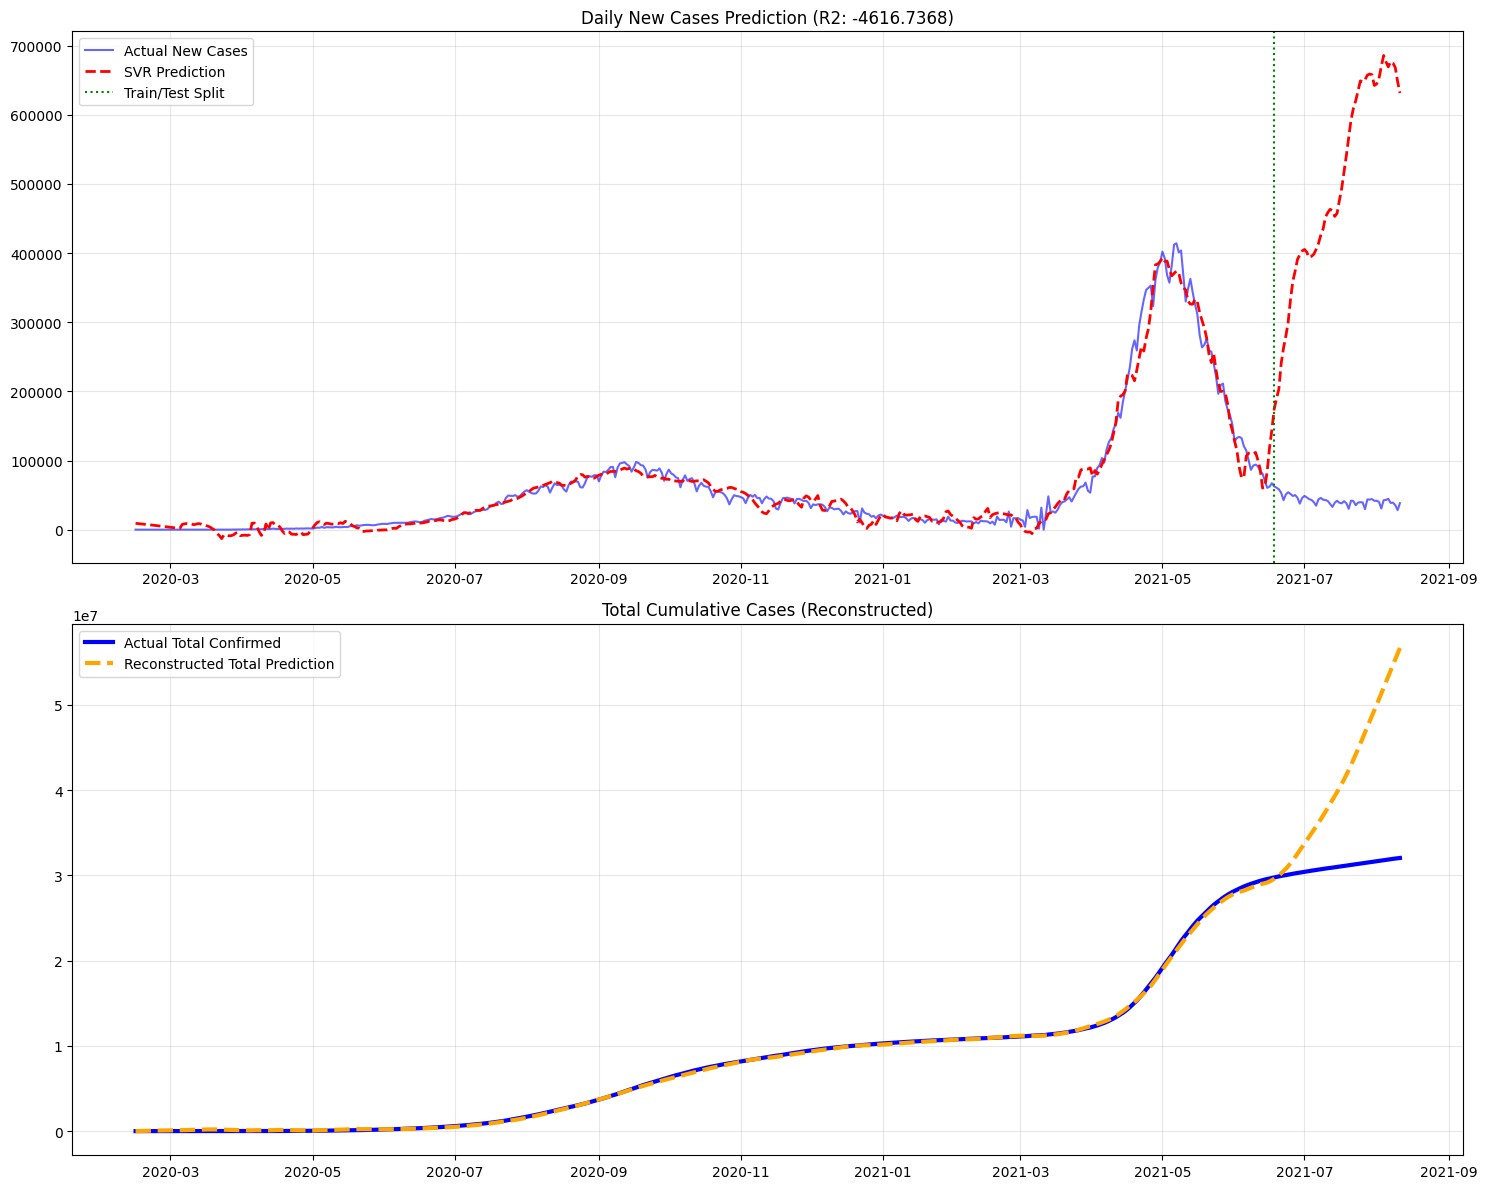

In [13]:
# 1. Predict Daily New Cases
y_pred_scaled = model.predict(X_test_scaled)
y_pred_new_cases = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Predict on ALL data for plotting
X_all_scaled = scaler_X.transform(X)
y_all_pred_scaled = model.predict(X_all_scaled)
y_all_pred_new_cases = scaler_y.inverse_transform(y_all_pred_scaled.reshape(-1, 1)).flatten()

# 2. Reconstruct CUMULATIVE (Total) Confirmed
# Total Prediction = (Actual Total at start) + (Accumulated Predicted New Cases)
master_df['Predicted_New_Cases'] = y_all_pred_new_cases
master_df['Predicted_Total_Confirmed'] = master_df['Predicted_New_Cases'].cumsum()

# Align the starting point of the prediction to reality for better visual comparison
initial_offset = master_df['Confirmed'].iloc[0] - master_df['Predicted_Total_Confirmed'].iloc[0]
master_df['Predicted_Total_Confirmed'] += initial_offset

# 3. Metrics
from sklearn.metrics import r2_score
r2_daily = r2_score(y_test, y_pred_new_cases)
print(f"Accuracy (R2) on Daily New Cases: {r2_daily:.4f}")

# 4. Plotting (Double Plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Daily New Cases (The Wave)
ax1.plot(master_df['Date'], master_df['New_Cases'], color='blue', alpha=0.6, label='Actual New Cases')
ax1.plot(master_df['Date'], master_df['Predicted_New_Cases'], color='red', linestyle='--', linewidth=2, label='SVR Prediction')
ax1.axvline(x=master_df['Date'].iloc[split_index], color='green', linestyle=':', label='Train/Test Split')
ax1.set_title(f'Daily New Cases Prediction (R2: {r2_daily:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Total Confirmed (The Curve)
ax2.plot(master_df['Date'], master_df['Confirmed'], color='blue', linewidth=3, label='Actual Total Confirmed')
ax2.plot(master_df['Date'], master_df['Predicted_Total_Confirmed'], color='orange', linestyle='--', linewidth=3, label='Reconstructed Total Prediction')
ax2.set_title('Total Cumulative Cases (Reconstructed)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()